# Drafting a SHAP-Based Model Monotonicity, 19-Jul-24

## Preamble

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set(
    style='ticks', 
    context='notebook', 
    font_scale=0.8, 
    rc={'figure.figsize': (6,4)}
)
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Roboto', 'Fira Sans']
rcParams['font.size'] = 10
rcParams['axes.titlesize'] = 12
rcParams['axes.labelsize'] = 10
rcParams['xtick.labelsize'] = 10
rcParams['ytick.labelsize'] = 10
rcParams['legend.fontsize'] = 'smaller'

In [3]:
import sklearn
sklearn.set_config(transform_output="pandas")
# sklearn.set_config(transform_output="default")

from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, RepeatedKFold, cross_validate
from sklearn.pipeline import Pipeline, make_pipeline

In [2]:
from rich import print
from rich.pretty import pprint
from rich import pretty
pretty.install()

In [6]:
from importlib import reload
import xai_metrics
from xai_metrics import monotonicity
# reload(xai_metrics)
import LG_MLUtils
from LG_MLUtils import (
    cross_validate_it, pivot_cross_validated_stats, get_CV_train_test_scores
)

In [7]:
import shap
shap.initjs()

<IPython.core.display.HTML object>

## Data Loading/Inspection/Preparation

In [8]:
ames = pd.read_csv('./')
ames.head(1)

FileNotFoundError: [Errno 2] No such file or directory: '../datasets/ames/train.csv'

In [55]:
ames.columns.sort_values()


Index(['1stFlrSF', '2ndFlrSF', '3SsnPorch', 'Alley', 'BedroomAbvGr',
       'BldgType', 'BsmtCond', 'BsmtExposure', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtFinType1', 'BsmtFinType2', 'BsmtFullBath', 'BsmtHalfBath',
       'BsmtQual', 'BsmtUnfSF', 'CentralAir', 'Condition1', 'Condition2',
       'Electrical', 'EnclosedPorch', 'ExterCond', 'ExterQual', 'Exterior1st',
       'Exterior2nd', 'Fence', 'FireplaceQu', 'Fireplaces', 'Foundation',
       'FullBath', 'Functional', 'GarageArea', 'GarageCars', 'GarageCond',
       'GarageFinish', 'GarageQual', 'GarageType', 'GarageYrBlt', 'GrLivArea',
       'HalfBath', 'Heating', 'HeatingQC', 'HouseStyle', 'Id', 'KitchenAbvGr',
       'KitchenQual', 'LandContour', 'LandSlope', 'LotArea', 'LotConfig',
       'LotFrontage', 'LotShape', 'LowQualFinSF', 'MSSubClass', 'MSZoning',
       'MasVnrArea', 'MasVnrType', 'MiscFeature', 'MiscVal', 'MoSold',
       'Neighborhood', 'OpenPorchSF', 'OverallCond', 'OverallQual',
       'PavedDrive', 'PoolArea', 'P

In [56]:
# for making things manageable, just a small subset of useful features
cols_of_interest = [
    'OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF',
    '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 'SalePrice'
]

In [57]:
ames = ames.loc[:, cols_of_interest]

In [58]:
ames['SalePrice'] = ames['SalePrice']/1000 

In [59]:
ames.head(1)

,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,1stFlrSF,FullBath,TotRmsAbvGrd,SalePrice
0,7,1710,2,548,856,856,2,8,208.5


<Axes: xlabel='SalePrice', ylabel='Count'>

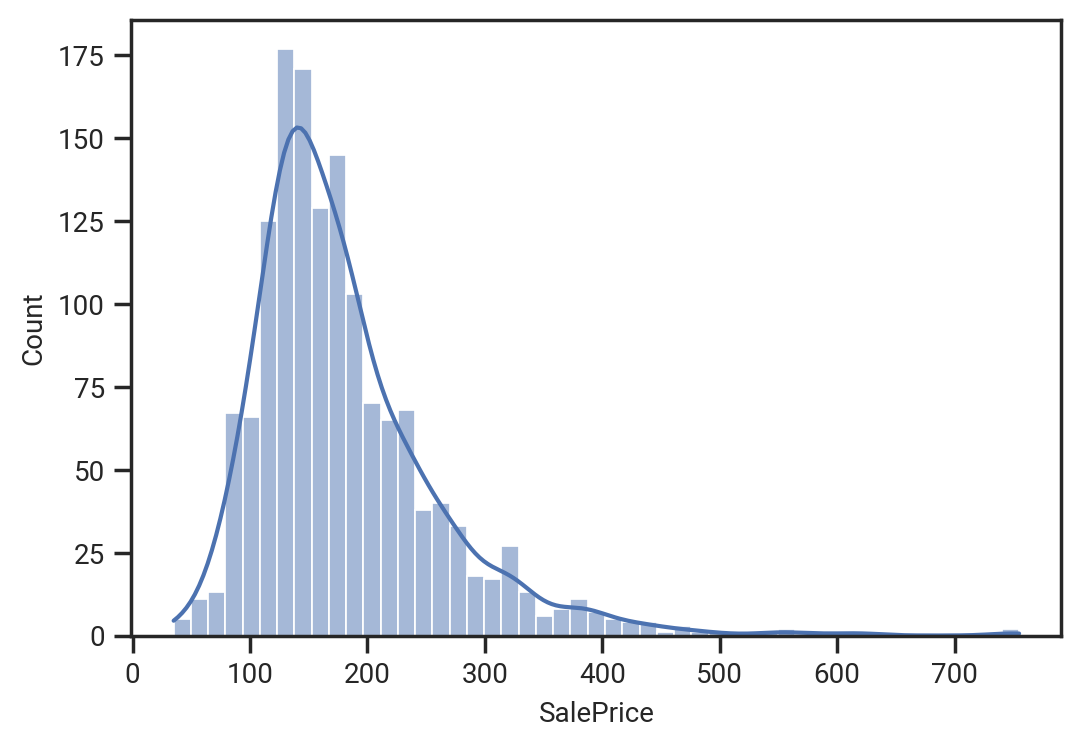

In [92]:
sns.histplot(x=ames['SalePrice'], kde=True)

In [94]:
ames.shape

(1460, 9)

In [95]:
# OK, let us remove some outliers for making it easier for the default models
ames = ames.query("SalePrice <= 450")

In [96]:
ames.shape

(1446, 9)

In [97]:
X, y = ames.drop(columns='SalePrice'), ames['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [98]:
X_train.shape

(1156, 8)

In [99]:
X_test.shape

(290, 8)

<Axes: xlabel='TotalBsmtSF', ylabel='SalePrice'>

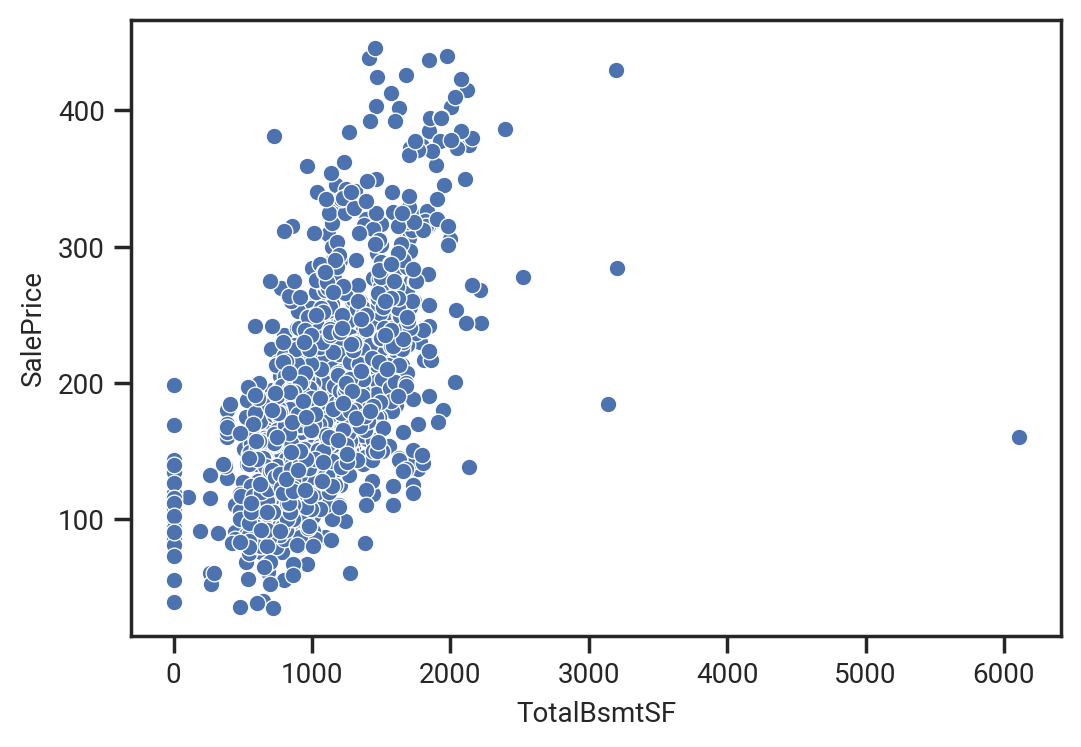

In [286]:
sns.scatterplot(x=ames['TotalBsmtSF'], y=ames['SalePrice'])

## A Default Random Forest

In [100]:
rf = RandomForestRegressor(
    max_depth=8, min_samples_split=30, min_samples_leaf=30, n_estimators=400
)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=8, min_samples_leaf=30, min_samples_split=30,
                      n_estimators=400)

In [101]:
cv_results_df = get_CV_train_test_scores(rf, X, y)
display(cv_results_df)

,test_mean,train_mean,test_std,train_std
metric,,,,
MAE,22.032257,20.521857,1.036176,0.341266
MAPE,0.137480,0.127510,0.006290,0.001377
RMSE,31.177872,29.297873,2.255592,0.607693
r2,0.798780,0.824257,0.017098,0.006652


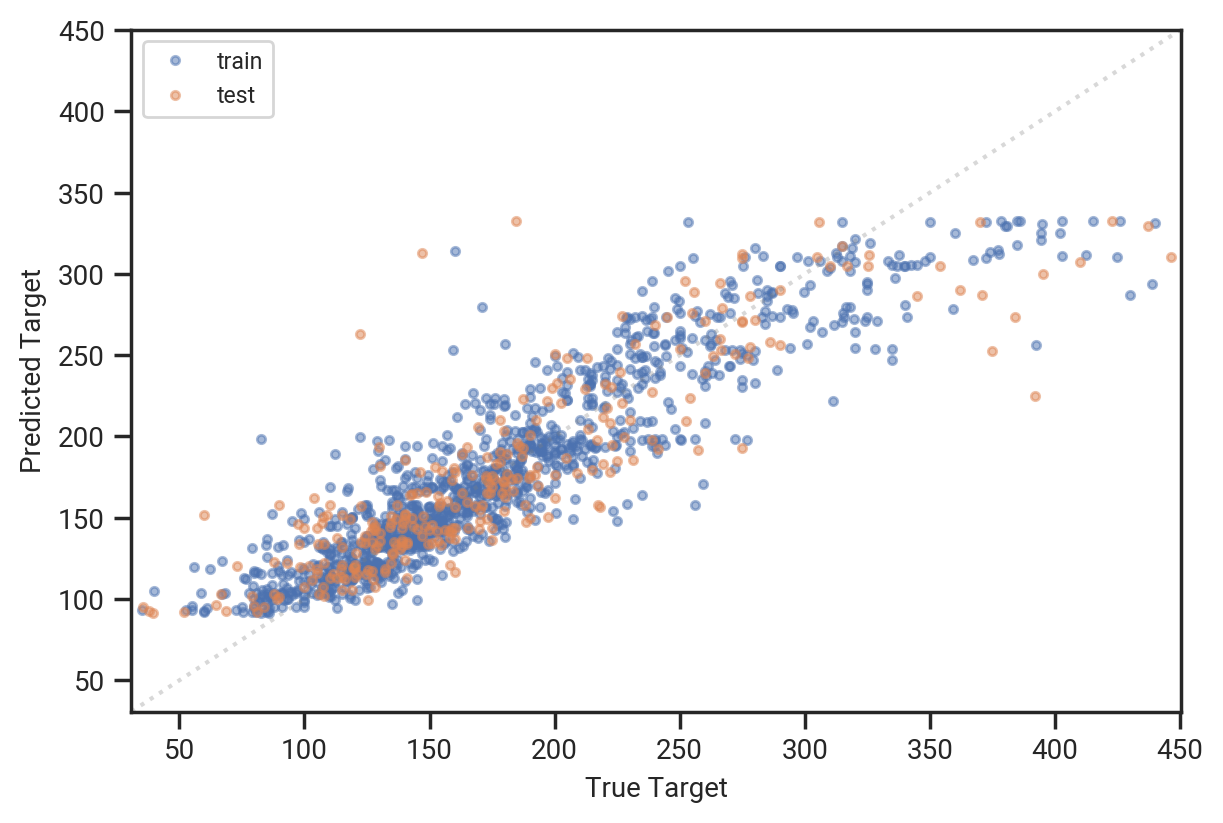

In [139]:
plot_true_vs_predicted(rf, X_train, y_train, X_test, y_test,
    train_style_kws=dict(alpha=0.5), test_style_kws=dict(alpha=0.5));

### SHAP

Instantiates a SHAP Explainer. In this case, as `model` is a Random Forest, I can make use of the more efficient implementation `TreeExplainer`. Normally, the explainer is "fitted" with the train data, but there doesn't seem to be hard guidance on this.

In [165]:
explainer = shap.TreeExplainer(rf, X_train)

I prefer to call `explanations` the output of an explainer; others call that `shap_values`, but I rather think of SHAP values as part of the explanations. We'll see why.

Again, to stick to the usual ML way, the explainer could be "applied" only to the test data, but I would like to work with the whole dataset for experimentation purposes.

In [178]:
explanations = explainer(X)

What does `explanations` look like in terms of structure for a regression problem?

In [179]:
type(explanations)

<class 'shap._explanation.Explanation'>